In [121]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values

import time

cudaq.set_target("nvidia")

# HAMILTONIAN BY CUDAQ

### by random values

In [122]:
B = 100
ret = np.array([1.0, 1.25, 1.5])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 1 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)


[[0.54755208 0.39360372 1.01524938]
 [0.39360372 1.76306622 0.50903263]
 [1.01524938 0.50903263 1.42755357]]
n_max: [1 1 1]
ret_bb: [1.   1.25 1.5 ]
n_qubit: 3


In [123]:
print("Hamiltonian:", H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-1+0i) * I0 + (1+0i) * Z0 + (1+0i) + (1+0i) * I0I1 + (-1+0i) * I0Z1 + (-1+0i) * Z0I1 + (1+0i) * Z0Z1 + (1+0i) * I0I2 + (-1+0i) * I0Z2 + (-1+0i) * Z0I2 + (1+0i) * Z0Z2 + (-1.125+0i) * I1 + (1.125+0i) * Z1 + (1+0i) * I1I2 + (-1+0i) * I1Z2 + (-1+0i) * Z1I2 + (1+0i) * Z1Z2 + (-1.25+0i) * I2 + (1.25+0i) * Z2
[0, 0, 0, 1, 1, 1, 2, 2, 2]
[1.0, -1.0, -1.0, -1.0, 1.125, -1.0, -1.0, -1.0, 1.25]

[0, 0, 1]
[1, 2, 2]
[1.0, 1.0, 1.0]


### by stock values

In [124]:
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

nn = 3
# B = 1500
B = 270
lamb = 1.5 # Budget Penalty
q = 0 # Volatility Weight
data_cov = data_cov.drop("Ticker", axis=1).iloc[:nn, :nn]
print(data_cov)
data_ret_p = data_ret_p.iloc[:nn]
# data_ret_p.loc[0, "Average_Return"] = 0.002070
# data_ret_p.loc[1, "Average_Return"] = 0.000050
# data_ret_p.loc[2, "Average_Return"] = 0.002070
print(data_ret_p)
stock_names = data_ret_p["Ticker"].tolist()
data_ret_p = data_ret_p.drop("Ticker", axis=1)

data_cov = data_cov.to_numpy()
data_ret_p = data_ret_p.to_numpy()

data_ret = data_ret_p[:, 0]
data_p = data_ret_p[:, 1]

print(data_cov.shape)
print(data_ret.round(5))
print(data_p.round(2))
print(stock_names)

       AAPL      ABBV       ABT
0  0.000772  0.000078  0.000100
1  0.000078  0.000279  0.000103
2  0.000100  0.000103  0.000256
  Ticker  Average_Return       Price
0   AAPL        0.001070  195.270004
1   ABBV        0.000832  183.259995
2    ABT        0.000706  131.300003
(3, 3)
[0.00107 0.00083 0.00071]
[195.27 183.26 131.3 ]
['AAPL', 'ABBV', 'ABT']


In [125]:
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, data_p, data_ret, data_cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)

n_max: [1 1 2]
ret_bb: [0.00077414 0.00056486 0.00034333 0.00068666]
n_qubit: 4


In [126]:
print(H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

(-0.692933+0i) * I0 + (0.692933+0i) * Z0 + (1.5+0i) + (0.736321+0i) * I0I1 + (-0.736321+0i) * I0Z1 + (-0.736321+0i) * Z0I1 + (0.736321+0i) * Z0Z1 + (0.52755+0i) * I0I2 + (-0.52755+0i) * I0Z2 + (-0.52755+0i) * Z0I2 + (0.52755+0i) * Z0Z2 + (1.0551+0i) * I0I3 + (-1.0551+0i) * I0Z3 + (-1.0551+0i) * Z0I3 + (1.0551+0i) * Z0Z3 + (-0.672877+0i) * I1 + (0.672877+0i) * Z1 + (0.495104+0i) * I1I2 + (-0.495104+0i) * I1Z2 + (-0.495104+0i) * Z1I2 + (0.495104+0i) * Z1Z2 + (0.990207+0i) * I1I3 + (-0.990207+0i) * I1Z3 + (-0.990207+0i) * Z1I3 + (0.990207+0i) * Z1Z3 + (-0.552253+0i) * I2 + (0.552253+0i) * Z2 + (0.709452+0i) * I2I3 + (-0.709452+0i) * I2Z3 + (-0.709452+0i) * Z2I3 + (0.709452+0i) * Z2Z3 + (-0.74978+0i) * I3 + (0.74978+0i) * Z3
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
[0.692932625294636, -0.7363205742864409, -0.5275504559031046, -1.0551009118062091, -0.7363205742864409, 0.6728767872082475, -0.4951036592183681, -0.9902073184367362, -0.5275504559031046, -0.4951036592183681, 0.5522530522

# CUDA QAOA

In [127]:
@cudaq.kernel
def realAmplitudeAnsatz(qreg: cudaq.qvector, qubit_count: int, ansatz: int, alpha: float):
    if ansatz == 0:
        for i in range(qubit_count):
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])
            rz(2.0*alpha, qreg[(i+1)%qubit_count])
            x.ctrl(qreg[i], qreg[(i+1)%qubit_count])

@cudaq.kernel
def mixingAnsatz(qreg: cudaq.qvector, qubit_count: int, beta: float):
    for i in range(qubit_count):
        rx(2.0*beta, qreg[i])

@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float], ansatz: int):
    qreg = cudaq.qvector(qubit_count)
    h(qreg)
    for i in range(layer_count):
        realAmplitudeAnsatz(qreg, qubit_count, ansatz, thetas[i])
        mixingAnsatz(qreg, qubit_count, thetas[layer_count + i])

In [128]:
# print(cudaq.draw(kernel_qaoa, 4, 2, [0.1]*4, 0))

In [129]:
@cudaq.kernel
def kernel_qaoa_ham(qubit_count: int, layer_count: int, thetas: List[float], idx_1: List[int], coeff_1: List[float], idx_2_a: List[int], idx_2_b: List[int], coeff_2: List[float]):
    qreg = cudaq.qvector(qubit_count)
    # qreg = cudaq.qvector(3)
    h(qreg)

    for i in range(layer_count):
        # for idxs, coeff, l in sorted_raw_ham:
        #     if l == 1:
        #         rz(2 * coeff * thetas[i], qreg[idxs[0]])
        #     elif l == 2:
        #         x.ctrl(qreg[idxs[0]], qreg[idxs[1]])
        #         rz(2 * coeff * thetas[i], qreg[idxs[1]])
        #         x.ctrl(qreg[idxs[0]], qreg[idxs[1]])
        # for i in range(qubit_count):
        #     rx(2.0 * thetas[layer_count + i], qreg[i])

        for j in range(len(idx_1)):
            rz(2 * coeff_1[j] * thetas[i], qreg[idx_1[j]])
        
        for j in range(len(idx_2_a)):
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])
            rz(2 * coeff_2[j] * thetas[i], qreg[idx_2_b[j]])
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])

        for j in range(qubit_count):
            rx(2.0 * thetas[layer_count + i], qreg[j])

In [130]:
idx_1_use, coeff_1_use = idx_1, coeff_1
idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a, idx_2_b, coeff_2

# idx_1_use, coeff_1_use = idx_1_qis, coeff_1_qis
# idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a_qis, idx_2_b_qis, coeff_2_qis

In [131]:
print(H)

(-0.692933+0i) * I0 + (0.692933+0i) * Z0 + (1.5+0i) + (0.736321+0i) * I0I1 + (-0.736321+0i) * I0Z1 + (-0.736321+0i) * Z0I1 + (0.736321+0i) * Z0Z1 + (0.52755+0i) * I0I2 + (-0.52755+0i) * I0Z2 + (-0.52755+0i) * Z0I2 + (0.52755+0i) * Z0Z2 + (1.0551+0i) * I0I3 + (-1.0551+0i) * I0Z3 + (-1.0551+0i) * Z0I3 + (1.0551+0i) * Z0Z3 + (-0.672877+0i) * I1 + (0.672877+0i) * Z1 + (0.495104+0i) * I1I2 + (-0.495104+0i) * I1Z2 + (-0.495104+0i) * Z1I2 + (0.495104+0i) * Z1Z2 + (0.990207+0i) * I1I3 + (-0.990207+0i) * I1Z3 + (-0.990207+0i) * Z1I3 + (0.990207+0i) * Z1Z3 + (-0.552253+0i) * I2 + (0.552253+0i) * Z2 + (0.709452+0i) * I2I3 + (-0.709452+0i) * I2Z3 + (-0.709452+0i) * Z2I3 + (0.709452+0i) * Z2Z3 + (-0.74978+0i) * I3 + (0.74978+0i) * Z3


In [132]:
print(cudaq.draw(kernel_qaoa_ham, n_qubit, 1, [0.5]*4, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)) 

     ╭───╮╭────────────╮ ╭─────────────╮╭─────────────╮╭────────────╮      »
q0 : ┤ h ├┤ rz(0.6929) ├─┤ rz(-0.7363) ├┤ rz(-0.5276) ├┤ rz(-1.055) ├───●──»
     ├───┤├────────────┴╮├────────────┬╯├─────────────┤├────────────┴╮╭─┴─╮»
q1 : ┤ h ├┤ rz(-0.7363) ├┤ rz(0.6729) ├─┤ rz(-0.4951) ├┤ rz(-0.9902) ├┤ x ├»
     ├───┤├─────────────┤├────────────┴╮├────────────┬╯├─────────────┤╰───╯»
q2 : ┤ h ├┤ rz(-0.5276) ├┤ rz(-0.4951) ├┤ rz(0.5523) ├─┤ rz(-0.7095) ├─────»
     ├───┤├────────────┬╯├─────────────┤├────────────┴╮├────────────┬╯     »
q3 : ┤ h ├┤ rz(-1.055) ├─┤ rz(-0.9902) ├┤ rz(-0.7095) ├┤ rz(0.7498) ├──────»
     ╰───╯╰────────────╯ ╰─────────────╯╰─────────────╯╰────────────╯      »

################################################################################

                                                                  ╭───────╮»
────────────────●────●──────────────────●────●─────────────────●──┤ rx(1) ├»
╭────────────╮╭─┴─╮  │                  │    │                 │  ╰───

# Ansatz Architecture

In [133]:
idx = 3
layer_count = 5

parameter_count = layer_count * 2

optimizer1 = cudaq.optimizers.NelderMead()
optimizer2 = cudaq.optimizers.COBYLA()
optimizer3 = cudaq.optimizers.SPSA()
optimizer4 = cudaq.optimizers.Adam()
optimizer5 = cudaq.optimizers.GradientDescent()

optimizer = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5][idx]
optimizer_names = ["Nelder-Mead", "COBYLA", "SPSA", "Adam", "GradientDescent"]
optimizer_name = optimizer_names[idx]
FIND_GRAD = True if optimizer.requires_gradients() else False

optimizer.max_iterations = 1000

optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [-0.26494246416913175, -0.3404074833621878, 0.3501137419781495, -0.16083111450588353, 0.22633407440665854, -0.02221903794518737, 0.1414056711393703, 0.3671920284695609, -0.07169730918222528, -0.28363177641905946]


# Optimize

In [134]:
expectations = []

def cost_func(parameters):
    # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
    return cudaq.observe(kernel_qaoa_ham, H, n_qubit, layer_count, parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [135]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()

if not os.path.exists("./output_PO"):
    os.makedirs("./output_PO")
np.save(f"./output_PO/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = 0.5410765788134769
optimal_parameters = [-0.20064175802145237, -0.28786506165155984, 0.43614983826799797, 0.004180770496066393, 0.3988981058650904, 0.09106664503748076, 0.09645331338384455, 0.3769873442296871, -0.08649343007029878, -0.2456340546792498]
Time taken =  0.32633423805236816


In [136]:
shots_count = int(1e6)
print(f"Sampling {shots_count} times...")
# result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)
result = cudaq.sample(kernel_qaoa_ham, int(n_qubit), layer_count, optimal_parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
# print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("|q0>|q1>|q2>...")



Sampling 1000000 times...
Finding the best solution...
0001 223100 0.2231
|q0>|q1>|q2>...


In [137]:
state = cudaq.get_state(kernel_qaoa_ham, int(n_qubit), layer_count, optimal_parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)
print(state)

for i in range(len(state)):
    bb = bin(i)[2:].zfill(n_qubit)
    print(bb, round(abs(state[i])**2, 4))

print(len(state))

SV: [(0.0430011,-0.0353433), (0.442193,0.09007), (0.439451,0.0807464), (0.170727,-0.0155903), (0.410227,0.0319677), (0.230894,0.0184957), (0.240369,0.0233209), (-0.0579288,0.0237231), (0.456696,0.120874), (0.0626421,-0.0199449), (0.0806782,-0.0216204), (0.00554104,0.0376094), (0.164812,-0.0032395), (-0.0304048,0.0681675), (-0.0384554,0.067242), (-0.0569814,0.0332541)]

0000 0.0031
0001 0.2232
0010 0.1693
0011 0.0272
0100 0.1996
0101 0.007
0110 0.0583
0111 0.006
1000 0.2036
1001 0.0043
1010 0.0537
1011 0.0056
1100 0.0294
1101 0.0014
1110 0.0039
1111 0.0044
16


In [138]:
assert False

AssertionError: 

In [139]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

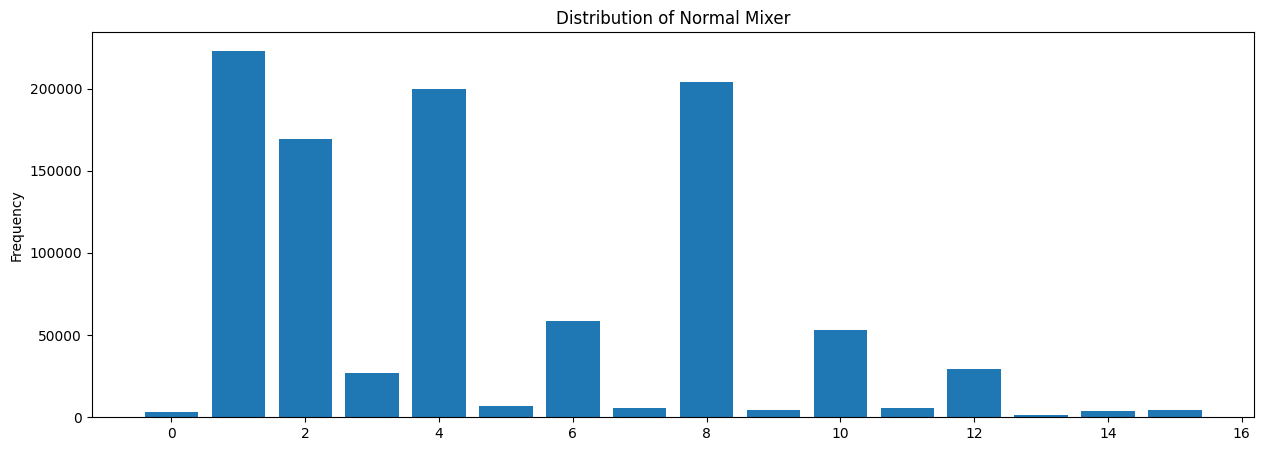

In [140]:
# plt.figure(figsize=(100, 15))
plt.figure(figsize=(15, 5))
# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final)
# plt.bar(range(int(2**(n_qubit-3)*0.1)), result_final[2**(n_qubit-3)*4:int(2**(n_qubit-3)*4.1)])
plt.ylabel('Frequency')
plt.title('Distribution of Normal Mixer')
# plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
plt.show()

Expectations file not found for Nelder-Mead
Expectations file not found for COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Expectations file not found for GradientDescent


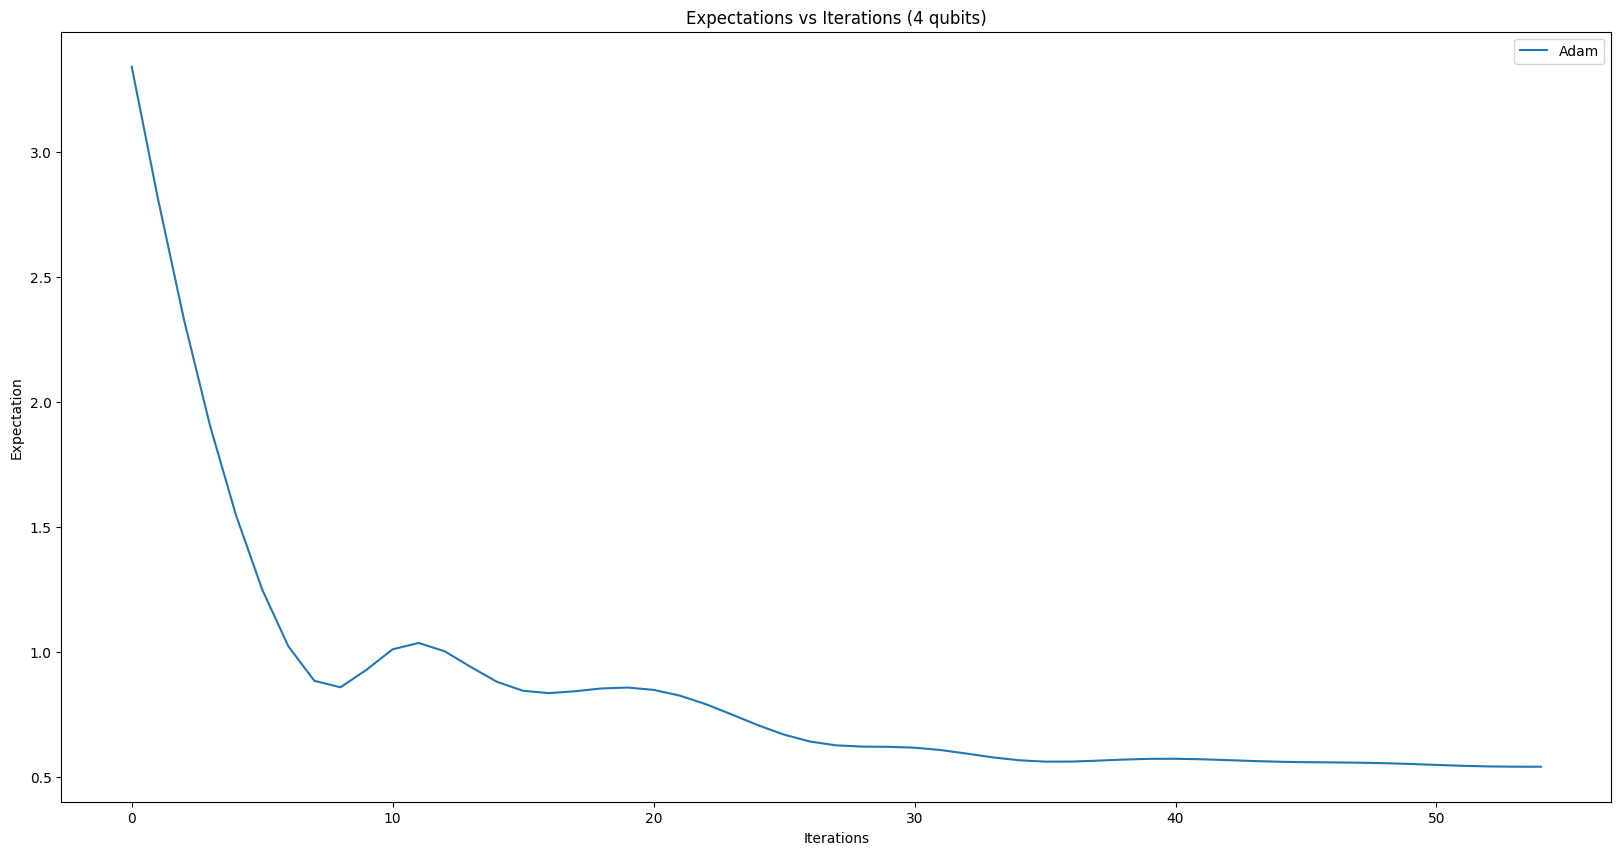

In [142]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()